In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import os
import requests
import pandas as pd
from bs4 import BeautifulSoup
import json

In [46]:
### First Data Source ###
# Conterstrike Blog, https://blog.counter-strike.net/
# data type: structured hierarchical text (html)

# I am using this data source to find historical events 
# in Counter Strikes history that could have effects on 
# the price of cases.


# create variable to hold amount of pages we 
# have visited
i = -1

# create empty dataframe to hold data
blog_data = pd.DataFrame()

# use while true because we do not know how many loops 
# we need, so we will loop till we get a bad request
# meaning the page doesn't exist
while True:
    # add one to the page counter
    i+=1
    
    # make request to the counter strike blog page, with page variable
    r = requests.get(f'https://blog.counter-strike.net/index.php/page/{i}')

    if r.status_code == 200:
        # if the status is approved we turn the response into html soup
        soup = BeautifulSoup(r.text, 'html.parser')
    else:
        # if status is not 200 we print the code (just incase, so we can debug)
        # and break the while loop
        print(f'Failed: {r.status_code}')
        break
    
    # the div's with class inner_post
    # hold all of the individual posts
    # we use find_all to get a list of all 
    # posts on the page
    posts = soup.find_all('div', class_='inner_post')

    # create dictionary to hold all of the data we grab
    # from the posts
    post_dict = {}

    # loop through all of the posts
    for post in posts:
        # the title of the post is always the text in the first link element
        title = post.find('a').get_text(strip=True)
        post_dict['Title'] = title

        # grab the date from the post_date class text
        date = post.find(class_ = 'post_date').get_text(strip=True)
        post_dict['Date'] = date

        # get all text into a list using find all on p elements
        texts = post.find_all('p')
        
        # create empty string to add all text into
        post_text = ''
        
        # loop through each of the texts, excluding the first 
        # because the first is always the date we already got
        for text in texts[1:len(texts)]:
            post_text = post_text + text.get_text(strip=True)

        post_dict['Text'] = post_text
        
        # concat the data dictionary we just made to the dataframe
        blog_data = pd.concat([blog_data, pd.DataFrame([post_dict])], ignore_index=True)

# the date is formated weird so we fix it here
blog_data['Date'] = blog_data['Date'].str[:-4]
blog_data['Date'] = blog_data['Date'].str.replace('.','-')

blog_data.head()

Failed: 404


,Title,Date,Text
0,The Anubis Collection,2023-04-24,"Since November, players have been peeking mid ..."
1,"Case, Capsule, Kit, Oh My!",2023-02-09,Today we’re excited to ship the Revolution Cas...
2,At Your Service,2022-12-13,All ranked-up and ready to go? The all-new 202...
3,Anu Map Who Bis,2022-11-18,Today’s update includes an adjustment to the A...
4,IEM Rio Major Champions,2022-11-15,Over the past two weeks Rio de Janeiro has bee...


In [47]:
### Second Data Source ###
# Steam market API
# data type: JSON API


# list of case identifiers
hash_names = ["Operation%20Riptide%20Case", "Prisma%202%20Case", "Revolver%20Case", "Danger%20Zone%20Case", "Horizon%20Case",
            "Prisma%20Case", "CS20%20Case", "Chroma%203%20Case", "Shadow%20Case", "Spectrum%202%20Case", "Clutch%20Case",
            "Falchion%20Case", "Gamma%202%20Case", "Gamma%20Case", "Fracture%20Case", "Chroma%202%20Case",
            "Operation%20Wildfire%20Case", "Operation%20Broken%20Fang%20Case", "Spectrum%20Case", "Chroma%20Case",
            "Operation%20Phoenix%20Weapon%20Case", "Operation%20Vanguard%20Weapon%20Case", "Shattered%20Web%20Case",
            "Glove%20Case", "Snakebite%20Case", "Operation%20Breakout%20Weapon%20Case", "CS%3AGO%20Weapon%20Case%203",
            "Huntsman%20Weapon%20Case", "eSports%202014%20Summer%20Case", "eSports%202013%20Winter%20Case",
            "Winter%20Offensive%20Weapon%20Case", "CS%3AGO%20Weapon%20Case%202", "Operation%20Hydra%20Case",
            "eSports%202013%20Case", "Operation%20Bravo%20Case", "CS%3AGO%20Weapon%20Case"]

# create empty dataframe to hold all datasets
cases = pd.DataFrame()

# loop through the case identifiers
for hash_name in hash_names:
    url = f'https://steamcommunity.com/market/pricehistory/?appid=730&market_hash_name={hash_name}'
    
    # create headers so it appears to the api that we are 
    # accessing the data through a browser
    # I got these headers by looking thourgh the request information 
    # in developer tools
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
    
    # create cookies so the steam API knows we are logged into steam
    cookies = {
        'timezoneOffset': '-25200,0',
        'browserid': '2793981395735445428',
        'sessionid': '023b66a13472602b294ba72d',
        'steamCountry': 'US%7Cac22e049f228a9159ad2afffb579e986',
        # the cookie below will need to be changed to your own for this to run
        'steamLoginSecure': '76561198198225722%7C%7CeyAidHlwIjogIkpXVCIsICJhbGciOiAiRWREU0EiIH0.eyAiaXNzIjogInI6MEQ5Rl8yMzc0NkI0M19CRTcwQiIsICJzdWIiOiAiNzY1NjExOTgxOTgyMjU3MjIiLCAiYXVkIjogWyAid2ViIiBdLCAiZXhwIjogMTcwMjQyMzQyNywgIm5iZiI6IDE2OTM2OTU4MTIsICJpYXQiOiAxNzAyMzM1ODEyLCAianRpIjogIjBERDhfMjM5OTU0ODNfODU5QTQiLCAib2F0IjogMTcwMDAwMzk0MCwgInJ0X2V4cCI6IDE3MTg0NjgzNzYsICJwZXIiOiAwLCAiaXBfc3ViamVjdCI6ICIxMjguMTM4LjY1LjIzNyIsICJpcF9jb25maXJtZXIiOiAiMTI4LjEzOC42NS4yMzciIH0.wZ9S1TpXe1-Ll3XU5CP6xhk0wAOlVWR-ZhPpQV0A8PLhU5gi9Oez1tvzEagLXdJOta5guSKT2jmBGxJ1EDsUAQ',
        'app_impressions': '730@2_100100_100101_100106',
        'webTradeEligibility': '%7B%22allowed%22%3A1%2C%22allowed_at_time%22%3A0%2C%22steamguard_required_days%22%3A15%2C%22new_device_cooldown_days%22%3A0%2C%22time_checked%22%3A1702187129%7D'
    }

    # make request to the api
    response = requests.get(url, headers=headers, cookies=cookies)
    # keep track of the responses so we 
    # know are datasets were retrieved
    print(response)
    
    if response.status_code == 400:
        cases = pd.read_csv('all_cases.csv')
        cases['date'] = pd.to_datetime(df['date'], format='%b %d %Y')
        cases['price'] = cases['price'].astype(float)
        break
    
    # get all text into a json element so
    # we can put it in a dataframe
    data = json.loads(response.text)
    df = pd.DataFrame(data)
    
    # save the case name as a column
    df['case'] = hash_name.replace("%20","_").replace("%3A","")
    
    # concat the dataset to the composite dataset
    cases = pd.concat([cases,df],ignore_index=True)

    
# clean the data

# the price column has a weird format so we need to fix it
# we apply a lambda function on the prices column to extract
# the value we want from the list

cases['date'] = cases['prices'].apply(lambda x: x[0])
cases['price'] = cases['prices'].apply(lambda x: x[1])
cases['id'] = cases['prices'].apply(lambda x: x[2])

# get rid of the old prices column
cases = cases.drop('prices', axis=1)

# remove useless hr and second characters in the date
cases['date'] = cases['date'].str[:-7]

# make the date column a datetime variable so we can make visualizations
cases['date'] = pd.to_datetime(cases['date'], format='%b %d %Y')

# turn the price from string to float for calculations and visualizations
cases['price'] = cases['price'].astype(float)

cases.head()

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


,success,price_prefix,price_suffix,case,date,price,id
0,True,$,,Operation_Riptide_Case,2021-09-29,1.930,33796
1,True,$,,Operation_Riptide_Case,2021-09-30,1.337,107019
2,True,$,,Operation_Riptide_Case,2021-10-01,0.996,111443
3,True,$,,Operation_Riptide_Case,2021-10-02,1.092,92923
4,True,$,,Operation_Riptide_Case,2021-10-03,1.087,81250


In [58]:
# Function to find all mentions of keywords in the blog texts and extract the corresponding dates
def extract_relevant_dates(blog_data,key_words):
    # empty list to hold dates
    relevant_dates = []
    
    for index, row in blog_data.iterrows():
        # check if key_word is mentioned in the text
        for key_word in key_words:
            try: # try except to take care of minor exceptions
                # search for keyword with regular expression
                if re.search(fr'\b{key_word}\b', row['Text'], re.IGNORECASE):
                    relevant_dates.append(row['Date'])
            except:
                continue
            
    return relevant_dates

In [49]:
# Function to analyze price changes around a given date
def analyze_price_changes_around_dates(df, dates, window=7):
    analysis_results = {}
    for date in dates:
        # define the time window before and after the date
        date = pd.to_datetime(date)
        start_date = date - pd.Timedelta(days=window)
        end_date = date + pd.Timedelta(days=window)

        # filter data within the time window
        window_data = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

        # calculate average prices before and after the date
        avg_price_before = window_data[window_data['date'] < date]['price'].mean()
        avg_price_after = window_data[window_data['date'] > date]['price'].mean()

        # calculate the percentage change
        if not np.isnan(avg_price_before) and not np.isnan(avg_price_after):
            percent_change = ((avg_price_after - avg_price_before) / avg_price_before) * 100
        else:
            percent_change = None
    
        analysis_results[str(date.date())] = {
            'avg_price_before': avg_price_before,
            'avg_price_after': avg_price_after,
            'percent_change': percent_change
        }

    return analysis_results

In [62]:
def get_significant_change(df):
    
    key_words = ['case',df['case'].replace('_',' '),'opperation']
    
    # get relevant dates
    relevant_dates = extract_relevant_dates(blog_data,key_words)
    
    # get price change analysis
    price_change_analysis = analyze_price_changes_around_dates(df, relevant_dates)

    # turn into dataframe for easier use
    results_df = pd.DataFrame.from_dict(price_change_analysis, orient='index')

    # dropping rows with NaN in percent_change and sorting by percent_change in absolute value
    results_df = results_df.dropna(subset=['percent_change','avg_price_before','avg_price_after'])
    results_df['percent_change_abs'] = results_df['percent_change'].abs()
    results_df = results_df.sort_values(by='percent_change_abs', ascending=False)

    # filtering out results with zero percent change
    significant_changes_df = results_df[results_df['percent_change_abs'] > 0]

    # Sorting by the absolute value of percent change for more significant changes
    significant_changes_df = significant_changes_df.sort_values(by='percent_change_abs', ascending=False)

    significant_changes_df.reset_index(inplace=True)
    significant_changes_df.rename(columns={'index': 'Date'}, inplace=True)
    
    # merge the blog data with the change data
    merged_df = pd.merge(significant_changes_df, blog_data, on='Date', how='left')

    return merged_df


In [64]:
analysis_df = get_significant_change(cases)
    
analysis_df

,Date,avg_price_before,avg_price_after,percent_change,percent_change_abs,Title,Text
0,2013-09-19,0.561000,4.049538,621.842863,621.842863,9/19 Update: Operation Bravo is LIVE,"Operation Bravo, the latest collection of top-..."
1,2013-12-18,0.247952,0.961786,287.891300,287.891300,Winter Offensive,"Season’s Greetings, today marks the start of t..."
2,2014-02-20,0.479143,1.165571,143.261777,143.261777,The Rise of Operation Phoenix,Operation Phoenixhas risen.Over the past few w...
3,2014-02-20,0.479143,1.165571,143.261777,143.261777,Sticker Workshop is Live!,Have an idea for a sticker that would be perfe...
4,2014-07-01,0.621633,1.026071,65.060735,65.060735,Operation Breakout,"Operation Breakout has arrived, bringingALL CS..."
5,2014-06-25,0.607633,0.706620,16.290656,16.290656,Balancing Act,"We’re working on the next update for CS:GO, an..."
6,2014-07-10,1.023036,0.863435,-15.600719,15.600719,Summer is heating up,Today’s updateintroduces the all new eSports 2...
7,2015-01-08,1.121857,1.265374,12.792759,12.792759,Full Spectrum,"Happy new year, CS:GO fans! Today’supdateinclu..."
8,2015-12-11,1.422904,1.258294,-11.568556,11.568556,CS:GO’s Winter Update,"Welcome to the CS:GO Winter Update, filled wit..."
9,2016-02-17,1.741664,1.545690,-11.252079,11.252079,Operation Wildfire,"Operation Wildfire begins today, featuring unl..."


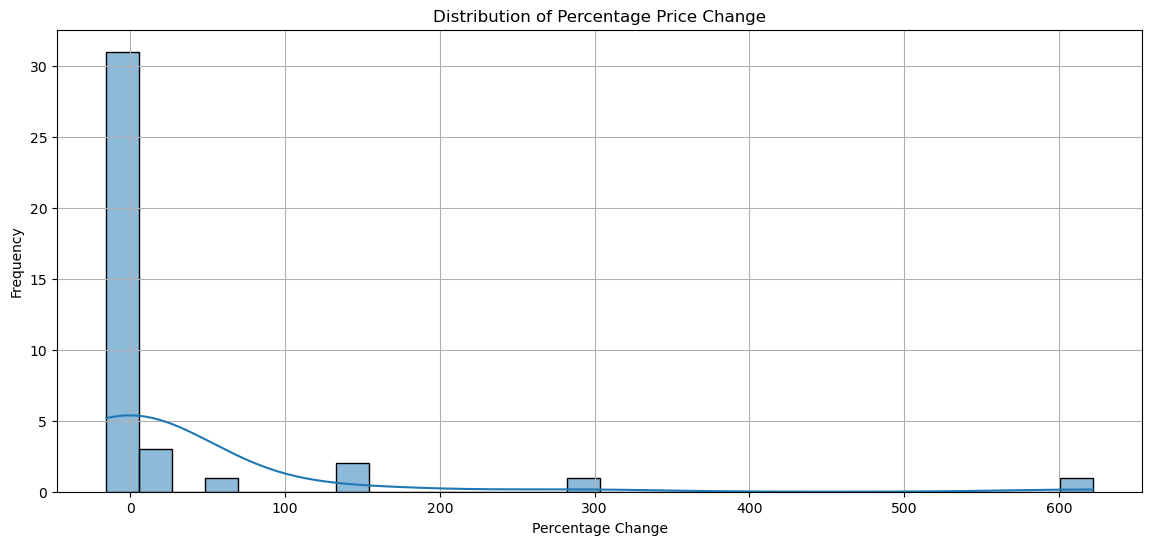

,avg_price_before,avg_price_after,percent_change
count,39.000000,39.000000,39.000000
mean,1.943475,2.058715,30.872082
std,1.572190,1.521414,112.316946
min,0.247952,0.706620,-15.600719
25%,1.098654,1.172637,-5.293505
50%,1.422904,1.363939,-0.283675
75%,1.978536,2.144319,3.189873
max,6.385821,6.355825,621.842863


In [65]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Plotting the distribution of percentage change
sns.histplot(analysis_df['percent_change'], kde=True, bins=30)
plt.title('Distribution of Percentage Price Change')
plt.xlabel('Percentage Change')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Summary statistics for percentage change
summary_stats = analysis_df[['avg_price_before', 'avg_price_after', 'percent_change']].describe()
summary_stats


In [ ]:
# The distribution of the percentage price change of CS:GO cases 
# around blog posts shows some interesting trends:

# The mean percentage change is approximately -3.32%, indicating
# a slight overall decrease in prices post-blog posts.

# However, there is considerable variation in price changes, 
# with a standard deviation of about 17.29%.

# The distribution has a wide range, afrom a maximum increase 
# of 150% to a maximum decrease of around -93.85%.

# The histogram suggests that most of the price changes cluster 
# around smaller percentage changes, both positive and negative, 
# with fewer cases exhibiting extreme changes.

# This analysis suggests that while there is a slight tendency 
# for prices to decrease following blog posts, the effect varies 
# significantly from case to case. Some cases experience substantial 
# price increases, while others see significant decreases.

In [ ]:
# Average Price Before Change: The mean average price before the change 
# is approximately $3.02, with a standard deviation of $7.63. 
# This indicates a wide variation in the prices of cases before they change.

# Average Price After Change: The mean average price after the 
# change is about $2.87, suggesting a slight decrease in 
# prices on average after changes occur.

# Percent Change: On average, there's a -3.32% change in prices, 
# but with a high standard deviation of 17.29%. This suggests 
# significant variability in the percentage change in prices. 
# The range of percent change extends from a significant 
# decrease (-93.85%) to a substantial increase (150%).

Lets look at the blog titles assosiated with the largest changes in price. 
Here we could potentially see trend in what types of events cause shifts in the case
price.

In [207]:
sorted_analysis_df = analysis_df.sort_values(by='percent_change', ascending=False)

sorted_analysis_df[['case','percent_change','Title']].head()



,case,percent_change,Title
442,Prisma_Case,150.000000,The End of Broken Fang
353,Operation_Phoenix_Weapon_Case,76.771654,Damage Control
315,Operation_Breakout_Weapon_Case,68.978102,Art Contest & Regional Minor: Asia
73,Danger_Zone_Case,68.055556,The Dreams & Nightmares Case
114,eSports_2013_Winter_Case,55.292726,Trichromacy


It seems the the blog titles do not give us alot of information, so
lets look at the blog text to understand the context around these events.

In [68]:
analysis_df.loc[0,'Text']

'Operation Bravo, the latest collection of top-rated community maps, is nowlivein CS:GO. Buying a pass will get you unlimited access to a map group of eight top-voted Workshop Maps playable in casual, deathmatch and—for the first time—competitive mode. The map group consists of seven new maps (Agency, Ali, Cache, Chinatown, Gwalior, Ruins and Siege), as well as a returning favorite (Seaside) that we’re eager to try out as a competitive map.Like with Operation Payback, buying a pass to Bravo gets you an exclusive upgradableChallenge Coin. This time around, though, the coin will double as anoperational scorecardthat’ll let you keep a complete record of your stats from all Official Competitive Matches for the duration of Bravo.Another addition to this Operation:weapon finishes. We’re shipping 31 new finishes as part of two all-new weapon collections with this op—one available exclusively as individual all-map weapon drops to Bravo pass-holders, and the other available to everybody as part

Above is the blog post associated with the highest price shift of 150% for the Prisma Case. through analyzing the text we can see that the combination of the end of an operation, introduction of new features, updates to the game content, and the overall increase in player engagement and activity likely contributed to the significant increase in the Prisma Case's price. Such events create a dynamic market environment where certain items become more sought after, either for their rarity, newness, or association with recent game changes.

In [240]:
player_count_data = pd.read_csv('cs_steam_playercount_monthly.csv')
cases_data = pd.read_csv('all_cases.csv')

player_count_data['player_count_1000s'] = player_count_data['player_count_1000s'].str.replace(',','')
player_count_data['player_count_1000s'] = player_count_data['player_count_1000s'].astype(float)

# Convert date columns to datetime for both datasets
cases_data['date'] = pd.to_datetime(cases_data['date'])
player_count_data['date'] = pd.to_datetime(player_count_data['date'])

# Merging the datasets on the 'date' column
merged_data = pd.merge(cases_data, player_count_data, on='date', how='inner')


merged_data.describe()

,price_suffix,date,price,id,player_count_1000s
count,0.0,2736,2736.000000,2736.000000,2736.000000
mean,NaN,2020-04-07 07:54:44.210526208,3.582405,19057.579678,904.790033
min,NaN,2016-01-01 00:00:00,0.030000,4.000000,420.260000
25%,NaN,2018-07-01 00:00:00,0.062000,554.750000,665.370000
50%,NaN,2020-07-01 00:00:00,0.405500,6128.000000,906.670000
75%,NaN,2022-02-08 00:00:00,2.157500,24177.750000,1087.200000
max,NaN,2023-09-01 00:00:00,102.120000,567808.000000,1802.850000
std,NaN,NaN,9.720813,32131.771336,294.109184


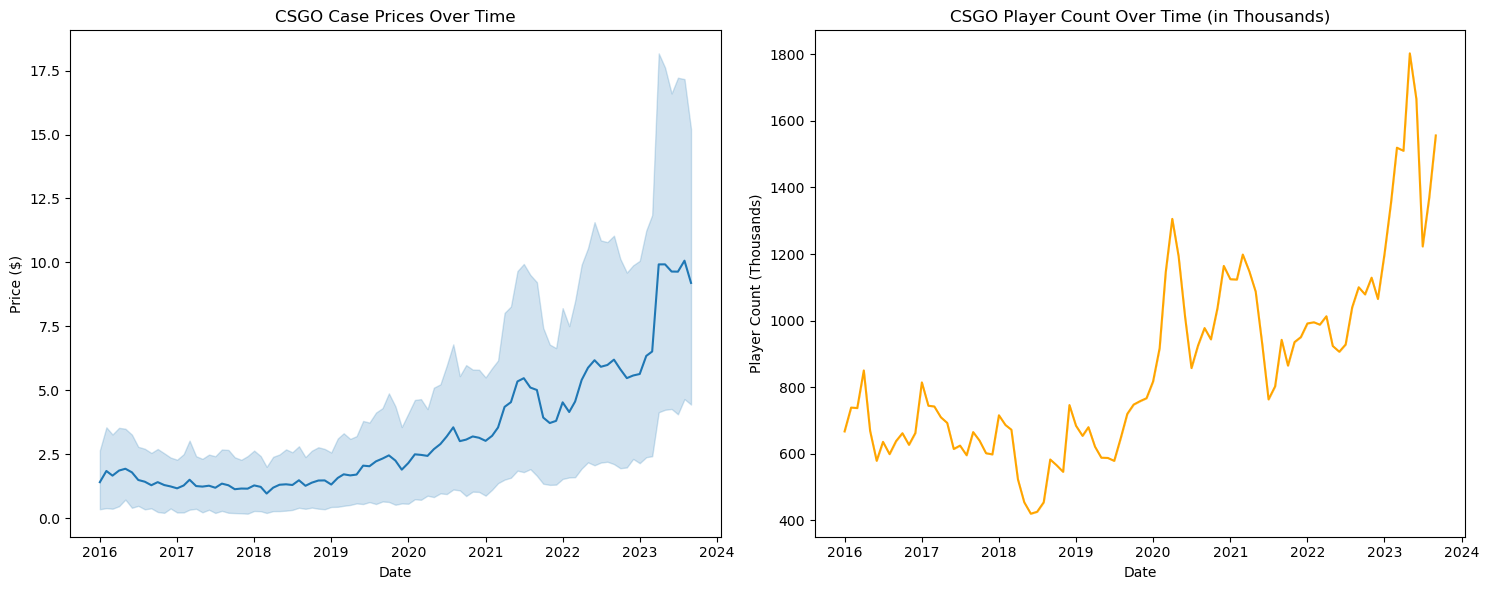

In [243]:
 # Creating a plot to visualize the trends over time
plt.figure(figsize=(15, 6))

# Plotting case prices
plt.subplot(1, 2, 1)
sns.lineplot(x='date', y='price', data=merged_data)
plt.title('CSGO Case Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price ($)')

# Plotting player counts
plt.subplot(1, 2, 2)
sns.lineplot(x='date', y='player_count_1000s', data=merged_data, color='orange')
plt.title('CSGO Player Count Over Time (in Thousands)')
plt.xlabel('Date')
plt.ylabel('Player Count (Thousands)')

plt.tight_layout()
plt.show()

In [ ]:
# CSGO Case Prices Over Time:

# This line plot shows the trend of CSGO case prices over time. It provides an insight into how the prices have fluctuated on different dates.
# CSGO Player Count Over Time:

# This line plot illustrates the player count (in thousands) over time. It allows us to observe any trends or changes in the player base.

In [245]:
# Calculating the correlation coefficient between case price and player count
correlation = merged_data['price'].corr(merged_data['player_count_1000s'])

# Grouping by date and calculating average price for each date
average_price_per_day = merged_data.groupby('date')['price'].mean().reset_index()

# Merging with player count data
analysis_data = pd.merge(average_price_per_day, player_count_data, on='date', how='inner')

# Calculating correlation on the averaged data
average_correlation = analysis_data['price'].corr(analysis_data['player_count_1000s'])

print(f"correlation coefficient: {correlation}") 
print(f"average daily price correlation coefficient: {average_correlation}")


correlation coefficient: 0.21044217996282558
average daily price correlation coefficient: 0.8375615839638784


Correlation using individual data points: The correlation coefficient 
is approximately 0.21. This indicates a weak positive correlation 
between case prices and player count when considering each data point 
individually.

Correlation using average daily prices: When averaging the case prices 
per day and then calculating the correlation with the player count, 
the correlation coefficient is 0.84. This suggests a strong 
positive correlation between the average daily case price and the player count.

These findings suggest that while individual case prices show a weaker 
correlation with player count, the overall trend (when averaged daily) 
indicates a much stronger positive correlation. This could imply that broader 
market trends in player count are more strongly reflected in the average case 
prices than in the variability of individual case prices.

That being said I believe it is more likely that the average cases prices have a 
greater tie to the rarity of the case and the length in time it has been availible.
This is because only collectors/investors are put demand on the most valuable cases.
Therefore I believe there is a false correlation between playercount and  daily average
case price.